In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import re
import seaborn as sns


from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
def formateaFecha(stringFecha, stringFormato):
    time = dt.datetime.strptime(stringFecha, stringFormato)
    return(time)

In [3]:
def calculaSegundoAcumulado(data):
    fechas = data.time
    seconds = list()
    
    fecha_old = data.time[0]
    s_count= 0
    
    for i in np.arange(0, len(data.time)):
        t= re.sub('\..*[^z|Z]', '', fechas[i])
        t= formateaFecha(t,'%Y-%m-%dT%H:%M:%SZ')       
        
        if(i==0):
            seconds.append(0)
        else:
            diff = t-fecha_old
            s_count = diff.seconds +s_count
            seconds.append(s_count) 
            
        fecha_old= t
            
    data["seconds"]=seconds

In [4]:
def calculaDistanciaAcumulada(data):
    distancias = data.distancia
    distAcu = list()
    
    distOld= 0
    for i in distancias:
        distOld = distOld+i     
        
        distAcu.append(distOld)
                       
    data["distanciaAcu"]=distAcu

In [5]:
def calculaElevacionAcumulada(data):
    inc_eles = data.inc_ele
    incEleAcu = list()
    
    incEleOld= 0
    for i in inc_eles:
        incEleOld = incEleOld+i     
        
        incEleAcu.append(incEleOld)
                       
    data["incEleAcu"]=incEleAcu

In [4]:
def calculaTiempoAcumulado(data):
    
    #Velocidad Vertical
    tiempo_menor_1=list()
    tiempo_mayor_1 = list()
    
    t_menor_1=0
    t_mayor_1=0
    
    #Pendiente
    tiempo_menor_0=list()
    tiempo_mayor_0=list()
    
    t_menor_0=0
    t_mayor_0=0
    
    #Velocidad
    tiempo_menor_7=list()
    tiempo_7_11 = list()
    tiempo_11_16 = list()
    tiempo_mayor_16 =list()
    
    t_menor_7=0
    t_7_11=0
    t_11_16 =0
    t_mayor_16=0
       
    fOldRow = data.time[0]
    
    for nrow in np.arange(0,len(data)):
        aux= re.sub('\..*[^z|Z]', '', data.time[nrow])
        aux= formateaFecha(aux,'%Y-%m-%dT%H:%M:%SZ')
        
        if(nrow !=0):
            
            
            t= aux - fOldRow 
            t= t.seconds
            
            vv= data.velocidad_v[nrow]
            p= data.pendiente[nrow]
            v= data.velocidad[nrow]
            
            if(vv<=1):
                t_menor_1= t_menor_1+t              
            else:
                t_mayor_1=t_mayor_1+t
                    
            if(p<0):
                t_menor_0= t_menor_0+t
            else:
                t_mayor_0=t_mayor_0+t
                
            if(v<=7):
                t_menor_7= t_menor_7+t
            elif(v>7 and v<=11):
                t_7_11=t_7_11+t
            elif(v>11 and v<=16):
                t_11_16=t_11_16+t                
            else:
                t_mayor_16=t_mayor_16+t        
                
        fOldRow = aux
                
        tiempo_menor_1.append(t_menor_1)
        tiempo_mayor_1.append(t_mayor_1)
        
        tiempo_menor_0.append(t_menor_0)
        tiempo_mayor_0.append(t_mayor_0)
        
        tiempo_menor_7.append(t_menor_7)
        tiempo_7_11.append(t_7_11)
        tiempo_11_16.append(t_11_16)
        tiempo_mayor_16.append(t_mayor_16)
                           
    data["tvv_menor_1"]= tiempo_menor_1
    data["tvv_mayor_1"]= tiempo_mayor_1
    
    data["tp_menor_0"]= tiempo_menor_0
    data["tp_mayor_0"]= tiempo_mayor_0
    
    data["tv_menor_7"]= tiempo_menor_7
    data["tv_7_11"]= tiempo_7_11
    data["tv_11_16"]= tiempo_11_16
    data["tv_mayor_16"]= tiempo_mayor_16

In [5]:
class elto:
    def __init__(self, velocidad, tiempo, pendiente, distancia):
        self.velocidad = velocidad
        self.tiempo = tiempo
        self.pendiente=pendiente
        self.distancia=distancia

In [6]:
def calculaVentana(data, umbralMin):
    cont = umbralMin*60
    
    nombreColV= "ventAvgV_"+str(umbralMin)+"_min"
    nombreColP= "ventAvgP_"+str(umbralMin)+"_min"
    nombreColD= "ventDAcu_"+str(umbralMin)+"_min"
    
    vent_v = list() # lista donde se guardan los promedios de velocidad X minutos antes
    vent_p = list() # lista donde se guardan los promedios de pendiente X minutos antes
    vent_d = list() # lista donde se guarda la distancia acumulada X minutos antes
    
    v_aux = list()  #lista donde se guardan las velocidades para hacer el avg
    p_aux = list()  #lista donde se guardan las pendientes para hacer el avg
    d_aux = list()  #lista donde se guardan las distancias para hacer el sum
    
    lista = list() #aquí se guardan los eltos para el contador
    sec_old = 0 
    
    for i in np.arange(0,len(data)):
        
        v = data.velocidad[i] #velocidad del trackpoint
        p = data.pendiente[i] #pendiente del trackpoint
        d = data.distancia[i] #distancia recorrida en ese trackpoint
        t = data.seconds[i]-sec_old #duración de ese trackpoint respecto al anterior
        sec_old = data.seconds[i]
        
        e_new= elto(v,t,p,d)
        
        #Si se supera el umbral...
        while(cont<=0): #mientras el contador sea <=0
            e_old=lista.pop(0) #Se saca el primer elemento de la cola
            cont = cont + e_old.tiempo #Se suma su tiempo al contador
            d_aux.pop(0) #Se saca el primer valor de distancia de la lista de distancias
            
            for j in np.arange(0,e_old.tiempo): #Por cada segundo de duración del elemento eliminado
                v_aux.pop(0)#Saco un valor de velocidad de la lista de velocidad
                p_aux.pop(0)#Saco un valor de pendiente de la lista de pendiente
        
        lista.append(e_new) #Añado el nuevo elemento
            
        cont= cont-e_new.tiempo #Resto su tiempo al contador
        
        rep = t
        
        if(t == 0): rep=1 #Si el tiempo del trackpoint es 0 rep sera 1, si no rep sera el tiempo del registro
        
        
        #Añado los valores de velocidad y pendiente * tiempo del registro para tener en cuenta 
        #los valores de forma ponderada para el avg.
        v_aux.extend([e_new.velocidad] * rep)
        p_aux.extend([e_new.pendiente] * rep)
        d_aux.append(e_new.distancia)
        
        
        if(len(v_aux) ==0):
            vent_v.append(0)
        else:
            vent_v.append(sum(v_aux)/len(v_aux))
            
        if(len(p_aux) ==0):
            vent_p.append(0)
        else:
            vent_p.append(sum(p_aux)/len(p_aux))
            
        vent_d.append(sum(d_aux))
        
    if(umbralMin !=1):                            
        data[nombreColD]= vent_d
        
    data[nombreColP]= vent_p
    data[nombreColV]= vent_v
       

In [7]:
import re

pathGeneral= "C:/Users/elsac/Documents/Master/TFM/Datos/activities_"

#Recorro los directorios de actividades
for i in np.arange(1,8):
    
    #Inicializo la lista donde recogere los archivos válidos
    lista = list()
    
    r=pathGeneral+str(i)+"/csv/trkps/dataRun/"
    
    listDocs= os.listdir(r)
        
    for j in listDocs:
        if re.search('Final', j) and not re.search('an_',j):
            lista.append(j)
        
    for j in lista:
        
        data = pd.read_csv(r+j, index_col=0)
        print(r+j)
    
        calculaSegundoAcumulado(data)
        calculaDistanciaAcumulada(data)
        calculaElevacionAcumulada(data)
    
        calculaTiempoAcumulado(data)
    
                
        calculaVentana(data, 1)
        calculaVentana(data, 5)
        calculaVentana(data, 10)
        calculaVentana(data, 15)

        try:        
            data = data.drop(['sport', 'time', 'latitud', 'longitud', 'elevacion', 'distancia', 'inc_ele','velocidad_v',
                              'direccion','cambio_dirr','seconds','cadencia','tv_16_20','tv_mayor_20',
                              'tvv_4_8', 'tvv_8_10', 'tvv_mayor_10', 'tp_menor_neg1','tp_neg1_neg05', 
                              'tp_neg05_0', 'tp_0_05', 'tp_05_1', 'tp_mayor_1','tvv_1_4'
                             ], axis=1)
        
        except:
            data = data.drop(['sport', 'time', 'latitud', 'longitud', 'elevacion', 'distancia', 'inc_ele','velocidad_v',
                              'direccion','cambio_dirr','seconds','cadencia'], axis=1)
            
        
        data.to_csv(r + "an_"+ j, index=False)
                

In [5]:
data1= pd.read_csv("C:/Users/elsac/Documents/Master/TFM/Datos/activities_3/csv/trkps/dataRun/1004529060_Final.csv", index_col=0)
data2=pd.read_csv("C:/Users/elsac/Documents/Master/TFM/Datos/activities_3/csv/trkps/dataRun/1034544981_Final.csv", index_col=0)
data3=pd.read_csv("C:/Users/elsac/Documents/Master/TFM/Datos/activities_3/csv/trkps/dataRun/1202118418_Final.csv", index_col=0)
data4=pd.read_csv("C:/Users/elsac/Documents/Master/TFM/Datos/activities_3/csv/trkps/dataRun/1358648872_Final.csv", index_col=0)
data5=pd.read_csv("C:/Users/elsac/Documents/Master/TFM/Datos/activities_3/csv/trkps/dataRun/1747417475_Final.csv", index_col=0)

In [3]:
andata1= pd.read_csv("C:/Users/elsac/Documents/Master/TFM/Datos/activities_3/csv/trkps/dataRun/an_1004529060_Final.csv")
andata2=pd.read_csv("C:/Users/elsac/Documents/Master/TFM/Datos/activities_3/csv/trkps/dataRun/an_1034544981_Final.csv")
andata3=pd.read_csv("C:/Users/elsac/Documents/Master/TFM/Datos/activities_3/csv/trkps/dataRun/an_1202118418_Final.csv")
andata4=pd.read_csv("C:/Users/elsac/Documents/Master/TFM/Datos/activities_3/csv/trkps/dataRun/an_1358648872_Final.csv")
andata5=pd.read_csv("C:/Users/elsac/Documents/Master/TFM/Datos/activities_3/csv/trkps/dataRun/an_1747417475_Final.csv")

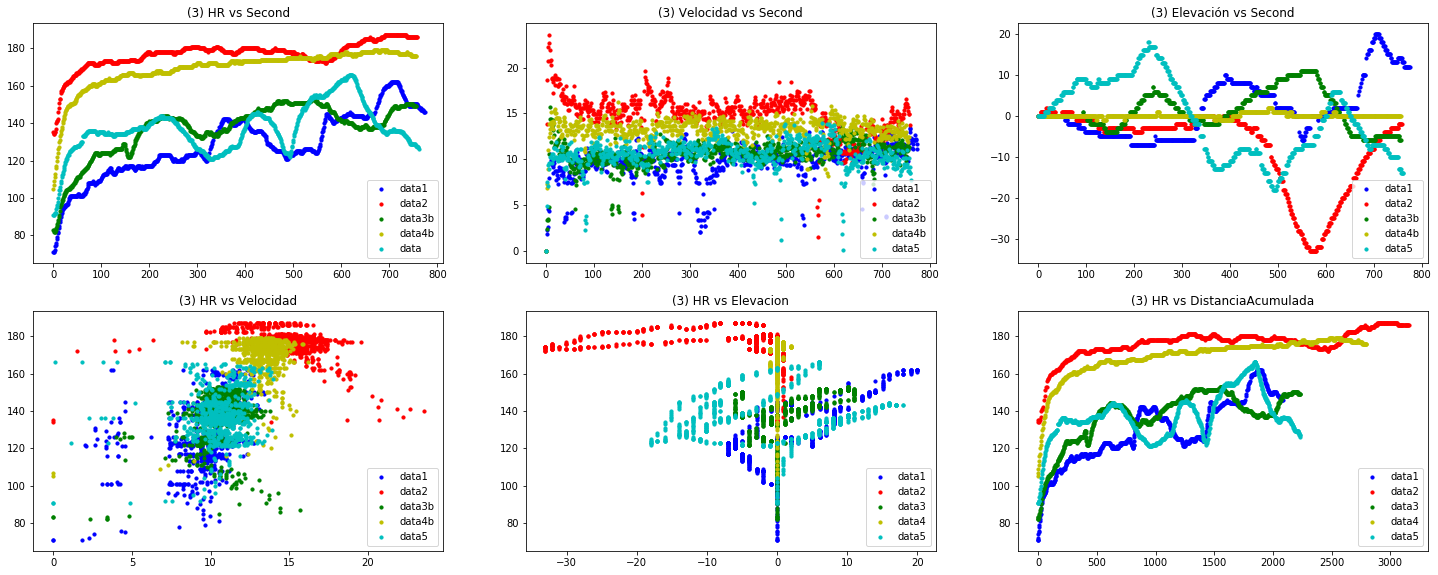

In [9]:
fig = plt.figure(figsize=(25,15))

data1b = data1[0:len(data2)-1]
data3b = data3[0:len(data2)-1]
data4b = data4[0:len(data2)-1]
data5b = data5[0:len(data2)-1]

ax1 = fig.add_subplot(331)
aux=ax1.scatter(data1b.seconds, data1b.hr, s=10, c='b', marker="o", label='data1')
aux=ax1.scatter(data2.seconds,data2.hr, s=10, c='r', marker="o", label='data2')
aux=ax1.scatter(data3b.seconds,data3b.hr, s=10, c='g', marker="o", label='data3b')
aux=ax1.scatter(data4b.seconds,data4b.hr, s=10, c='y', marker="o", label='data4b')
aux=ax1.scatter(data5b.seconds,data5b.hr, s=10, c='c', marker="o", label='data')
aux=plt.legend(loc='lower right');
aux=plt.title("(3) HR vs Second")

ax1 = fig.add_subplot(332)
aux=ax1.scatter(data1b.seconds, data1b.velocidad, s=10, c='b',marker="o", label='data1')
aux=ax1.scatter(data2.seconds,data2.velocidad, s=10, c='r', marker="o", label='data2')
aux=ax1.scatter(data3b.seconds,data3b.velocidad, s=10, c='g', marker="o", label='data3b')
aux=ax1.scatter(data4b.seconds,data4b.velocidad, s=10, c='y', marker="o", label='data4b')
aux=ax1.scatter(data5b.seconds,data5b.velocidad, s=10, c='c', marker="o", label='data5')
aux=plt.legend(loc='lower right');
aux=plt.title("(3) Velocidad vs Second")

ax1 = fig.add_subplot(333)
aux=ax1.scatter(data1b.seconds, data1b.incEleAcu, s=10, c='b',marker="o", label='data1')
aux=ax1.scatter(data2.seconds,data2.incEleAcu, s=10, c='r', marker="o", label='data2')
aux=ax1.scatter(data3b.seconds,data3b.incEleAcu, s=10, c='g', marker="o", label='data3b')
aux=ax1.scatter(data4b.seconds,data4b.incEleAcu, s=10, c='y', marker="o", label='data4b')
aux=ax1.scatter(data5b.seconds,data5b.incEleAcu, s=10, c='c', marker="o", label='data5')
aux=plt.legend(loc='lower right');
aux=plt.title("(3) Elevación vs Second")

ax1 = fig.add_subplot(334)
aux=ax1.scatter(data1b.velocidad, data1b.hr, s=10, c='b',marker="o", label='data1')
aux=ax1.scatter(data2.velocidad,data2.hr, s=10, c='r', marker="o", label='data2')
aux=ax1.scatter(data3b.velocidad,data3b.hr, s=10, c='g', marker="o", label='data3b')
aux=ax1.scatter(data4b.velocidad,data4b.hr, s=10, c='y', marker="o", label='data4b')
aux=ax1.scatter(data5b.velocidad,data5b.hr, s=10, c='c', marker="o", label='data5')
aux=plt.legend(loc='lower right');
aux=plt.title("(3) HR vs Velocidad")

ax1 = fig.add_subplot(335)
aux=ax1.scatter(data1b.incEleAcu, data1b.hr, s=10, c='b',marker="o", label='data1')
aux=ax1.scatter(data2.incEleAcu,data2.hr, s=10, c='r', marker="o", label='data2')
aux=ax1.scatter(data3b.incEleAcu,data3b.hr, s=10, c='g', marker="o", label='data3')
aux=ax1.scatter(data4b.incEleAcu,data4b.hr, s=10, c='y', marker="o", label='data4')
aux=ax1.scatter(data5b.incEleAcu,data5b.hr, s=10, c='c', marker="o", label='data5')
aux=plt.legend(loc='lower right');
aux=plt.title("(3) HR vs Elevacion")

ax1 = fig.add_subplot(336)
aux=ax1.scatter(data1b.distanciaAcu, data1b.hr, s=10, c='b',marker="o", label='data1')
aux=ax1.scatter(data2.distanciaAcu,data2.hr, s=10, c='r', marker="o", label='data2')
aux=ax1.scatter(data3b.distanciaAcu,data3b.hr, s=10, c='g', marker="o", label='data3')
aux=ax1.scatter(data4b.distanciaAcu,data4b.hr, s=10, c='y', marker="o", label='data4')
aux=ax1.scatter(data5b.distanciaAcu,data5b.hr, s=10, c='c', marker="o", label='data5')
aux=plt.legend(loc='lower right');
aux=plt.title("(3) HR vs DistanciaAcumulada")



aux=plt.show()

### Acumuladores de tiempo a X valor de X característica

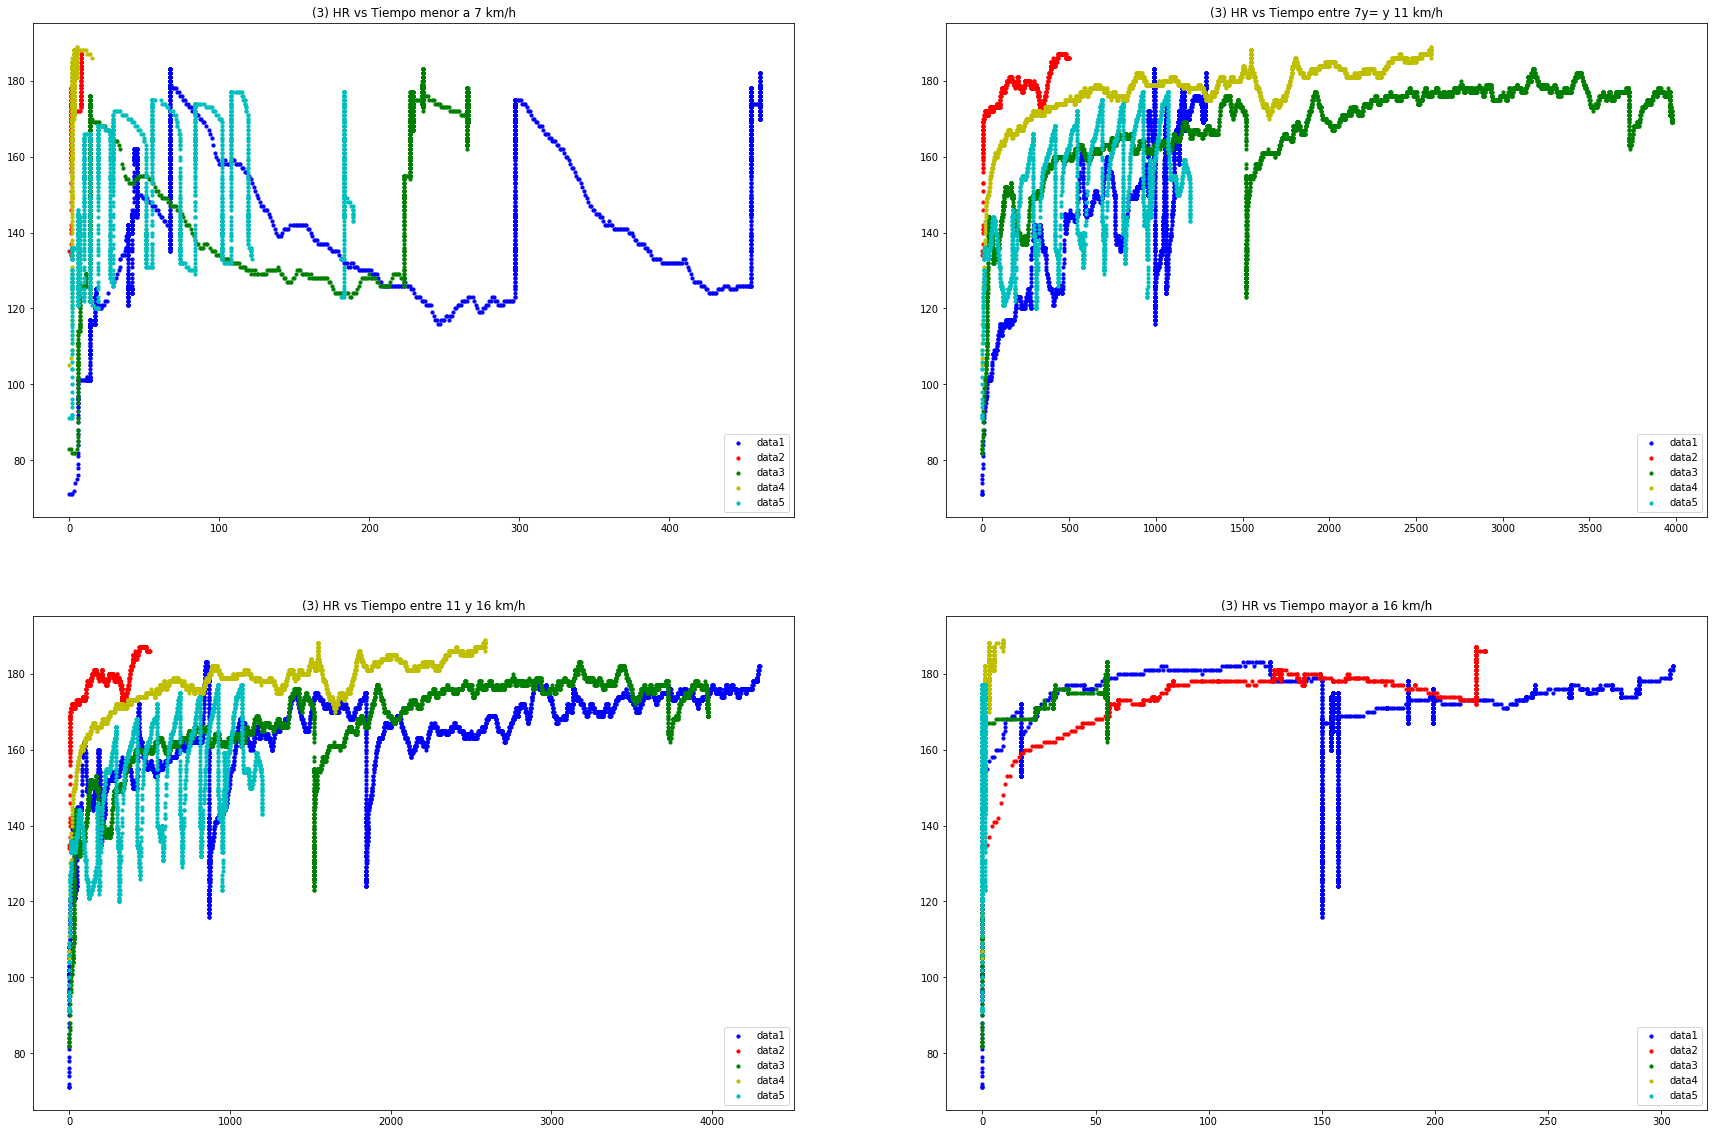

In [22]:
fig = plt.figure(figsize=(30,20))

andata1b = andata1[0:len(andata2)-1]
andata3b = andata3[0:len(andata2)-1]
andata4b = andata4[0:len(andata2)-1]
andata5b = andata5[0:len(andata2)-1]


ax1 = fig.add_subplot(221)
aux=ax1.scatter(andata1.tv_menor_7, andata1.hr, s=10, c='b',marker="o", label='data1')
aux=ax1.scatter(andata2.tv_menor_7, andata2.hr, s=10, c='r', marker="o", label='data2')
aux=ax1.scatter(andata3.tv_menor_7, andata3.hr, s=10, c='g', marker="o", label='data3')
aux=ax1.scatter(andata4.tv_menor_7, andata4.hr, s=10, c='y', marker="o", label='data4')
aux=ax1.scatter(andata5.tv_menor_7, andata5.hr, s=10, c='c', marker="o", label='data5')
aux=plt.legend(loc='lower right');
aux=plt.title("(3) HR vs Tiempo menor a 7 km/h")

ax1 = fig.add_subplot(222)
aux=ax1.scatter(andata1.tv_7_11, andata1.hr, s=10, c='b',marker="o", label='data1')
aux=ax1.scatter(andata2.tv_11_16, andata2.hr, s=10, c='r', marker="o", label='data2')
aux=ax1.scatter(andata3.tv_11_16, andata3.hr, s=10, c='g', marker="o", label='data3')
aux=ax1.scatter(andata4.tv_11_16, andata4.hr, s=10, c='y', marker="o", label='data4')
aux=ax1.scatter(andata5.tv_11_16, andata5.hr, s=10, c='c', marker="o", label='data5')
aux=plt.legend(loc='lower right');
aux=plt.title("(3) HR vs Tiempo entre 7y= y 11 km/h")

ax1 = fig.add_subplot(223)
aux=ax1.scatter(andata1.tv_11_16, andata1.hr, s=10, c='b',marker="o", label='data1')
aux=ax1.scatter(andata2.tv_11_16, andata2.hr, s=10, c='r', marker="o", label='data2')
aux=ax1.scatter(andata3.tv_11_16, andata3.hr, s=10, c='g', marker="o", label='data3')
aux=ax1.scatter(andata4.tv_11_16, andata4.hr, s=10, c='y', marker="o", label='data4')
aux=ax1.scatter(andata5.tv_11_16, andata5.hr, s=10, c='c', marker="o", label='data5')
aux=plt.legend(loc='lower right');
aux=plt.title("(3) HR vs Tiempo entre 11 y 16 km/h")


ax1 = fig.add_subplot(224)
aux=ax1.scatter(andata1.tv_mayor_16, andata1.hr, s=10, c='b',marker="o", label='data1')
aux=ax1.scatter(andata2.tv_mayor_16, andata2.hr, s=10, c='r', marker="o", label='data2')
aux=ax1.scatter(andata3.tv_mayor_16, andata3.hr, s=10, c='g', marker="o", label='data3')
aux=ax1.scatter(andata4.tv_mayor_16, andata4.hr, s=10, c='y', marker="o", label='data4')
aux=ax1.scatter(andata5.tv_mayor_16, andata5.hr, s=10, c='c', marker="o", label='data5')
aux=plt.legend(loc='lower right');
aux=plt.title("(3) HR vs Tiempo mayor a 16 km/h")

aux=plt.show()

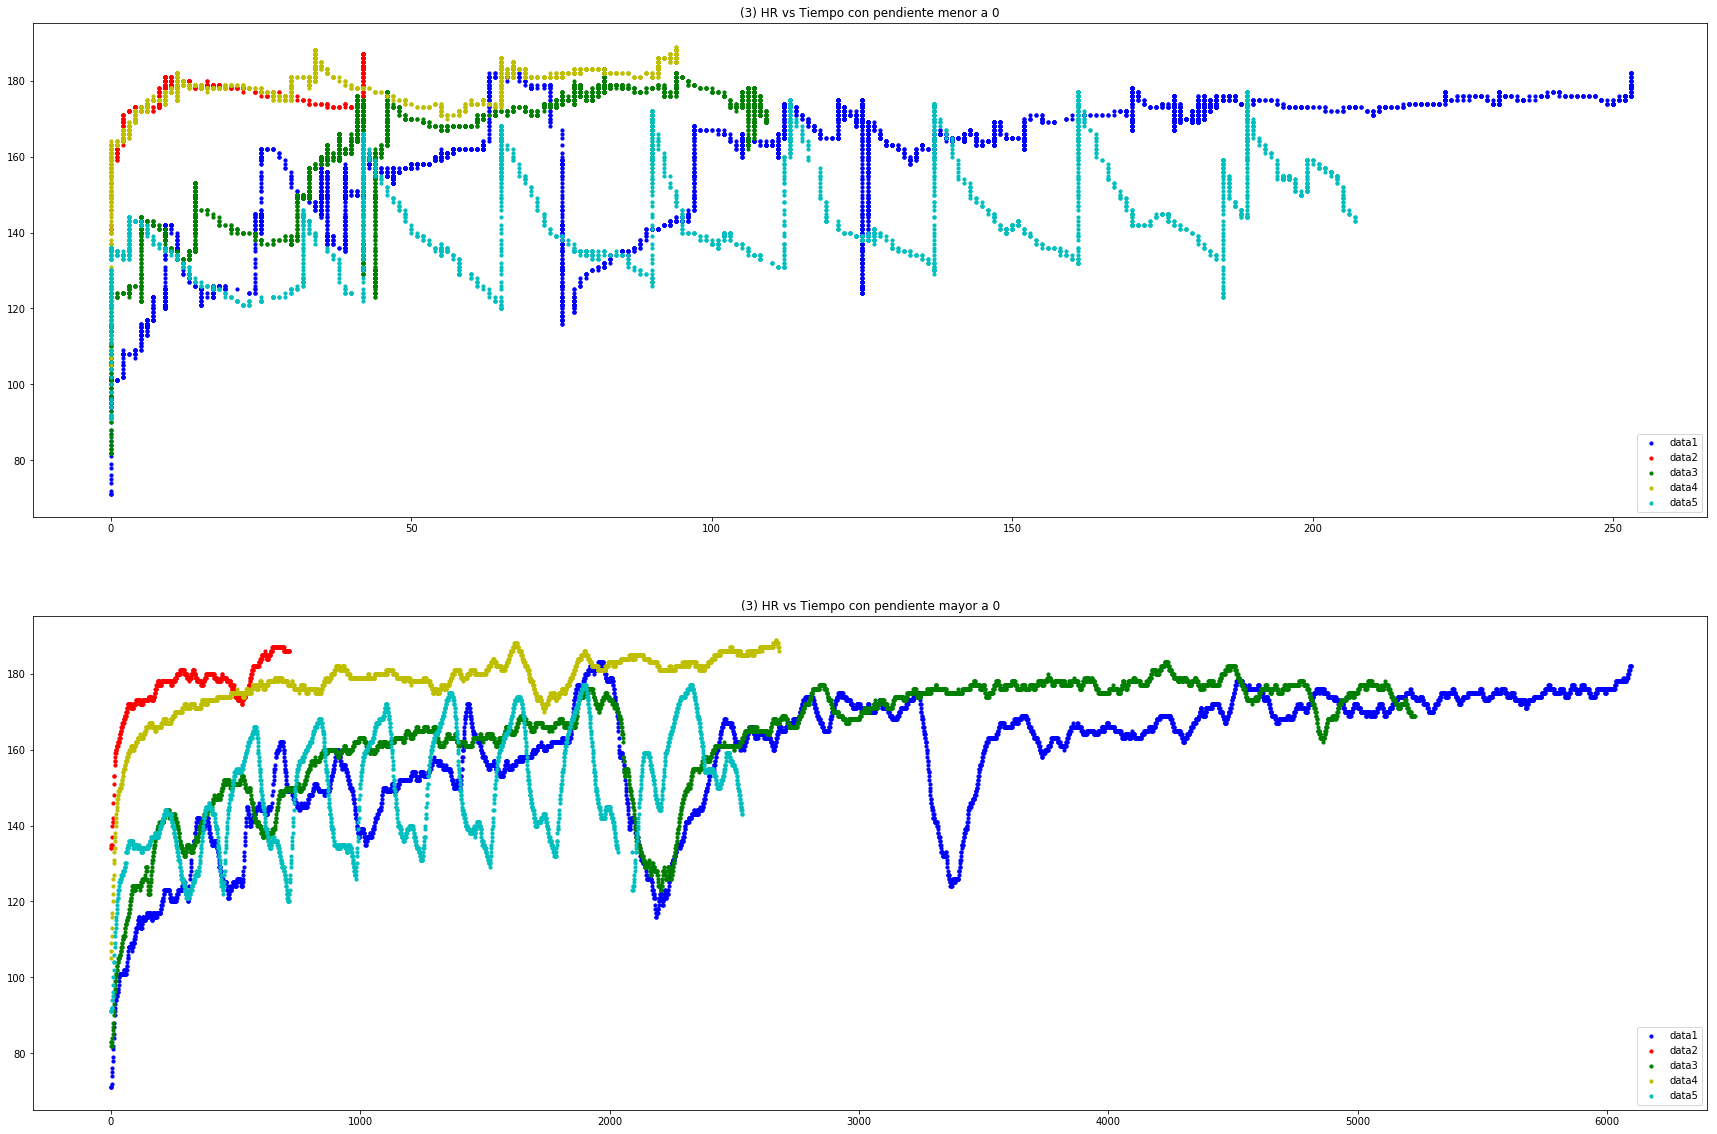

In [23]:
fig = plt.figure(figsize=(30,20))

andata1b = andata1[0:len(andata2)-1]
andata3b = andata3[0:len(andata2)-1]
andata4b = andata4[0:len(andata2)-1]
andata5b = andata5[0:len(andata2)-1]


ax1 = fig.add_subplot(211)
aux=ax1.scatter(andata1.tp_menor_0, andata1.hr, s=10, c='b',marker="o", label='data1')
aux=ax1.scatter(andata2.tp_menor_0, andata2.hr, s=10, c='r', marker="o", label='data2')
aux=ax1.scatter(andata3.tp_menor_0, andata3.hr, s=10, c='g', marker="o", label='data3')
aux=ax1.scatter(andata4.tp_menor_0, andata4.hr, s=10, c='y', marker="o", label='data4')
aux=ax1.scatter(andata5.tp_menor_0, andata5.hr, s=10, c='c', marker="o", label='data5')
aux=plt.legend(loc='lower right');
aux=plt.title("(3) HR vs Tiempo con pendiente menor a 0")


ax1 = fig.add_subplot(212)
aux=ax1.scatter(andata1.tp_mayor_0, andata1.hr, s=10, c='b',marker="o", label='data1')
aux=ax1.scatter(andata2.tp_mayor_0, andata2.hr, s=10, c='r', marker="o", label='data2')
aux=ax1.scatter(andata3.tp_mayor_0, andata3.hr, s=10, c='g', marker="o", label='data3')
aux=ax1.scatter(andata4.tp_mayor_0, andata4.hr, s=10, c='y', marker="o", label='data4')
aux=ax1.scatter(andata5.tp_mayor_0, andata5.hr, s=10, c='c', marker="o", label='data5')
aux=plt.legend(loc='lower right');
aux=plt.title("(3) HR vs Tiempo con pendiente mayor a 0")


aux=plt.show()

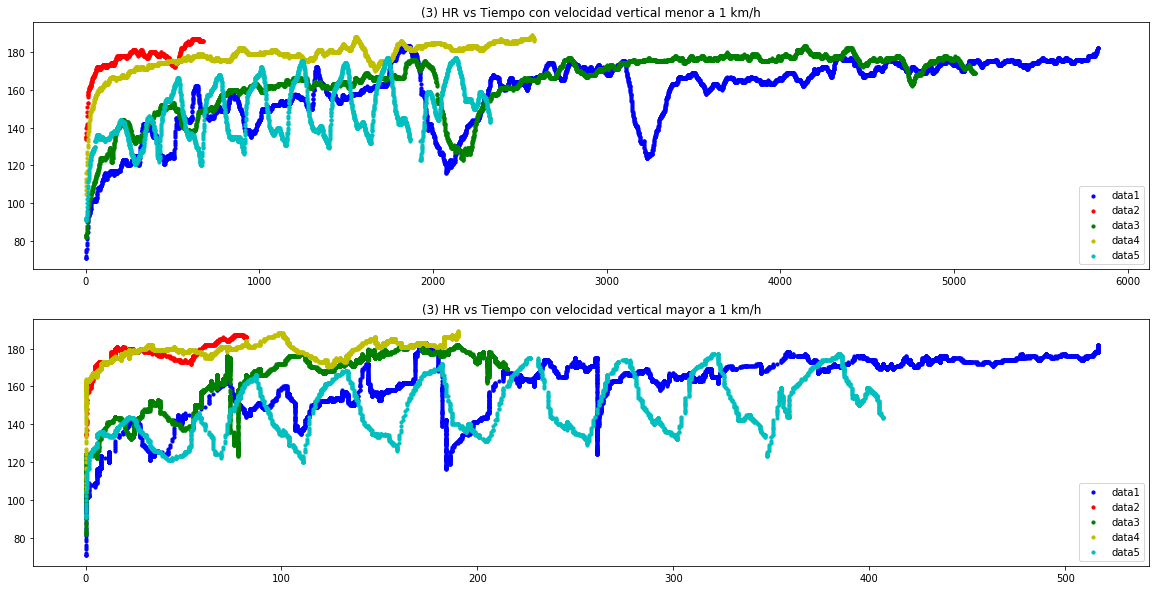

In [42]:
fig = plt.figure(figsize=(20,10))

andata1b = andata1[0:len(andata2)-1]
andata3b = andata3[0:len(andata2)-1]
andata4b = andata4[0:len(andata2)-1]
andata5b = andata5[0:len(andata2)-1]


ax1 = fig.add_subplot(211)
aux=ax1.scatter(andata1.tvv_menor_1, andata1.hr, s=10, c='b',marker="o", label='data1')
aux=ax1.scatter(andata2.tvv_menor_1, andata2.hr, s=10, c='r', marker="o", label='data2')
aux=ax1.scatter(andata3.tvv_menor_1, andata3.hr, s=10, c='g', marker="o", label='data3')
aux=ax1.scatter(andata4.tvv_menor_1, andata4.hr, s=10, c='y', marker="o", label='data4')
aux=ax1.scatter(andata5.tvv_menor_1, andata5.hr, s=10, c='c', marker="o", label='data5')
aux=plt.legend(loc='lower right');
aux=plt.title("(3) HR vs Tiempo con velocidad vertical menor a 1 km/h")

ax1 = fig.add_subplot(212)
aux=ax1.scatter(andata1.tvv_mayor_1, andata1.hr, s=10, c='b',marker="o", label='data1')
aux=ax1.scatter(andata2.tvv_mayor_1, andata2.hr, s=10, c='r', marker="o", label='data2')
aux=ax1.scatter(andata3.tvv_mayor_1, andata3.hr, s=10, c='g', marker="o", label='data3')
aux=ax1.scatter(andata4.tvv_mayor_1, andata4.hr, s=10, c='y', marker="o", label='data4')
aux=ax1.scatter(andata5.tvv_mayor_1, andata5.hr, s=10, c='c', marker="o", label='data5')
aux=plt.legend(loc='lower right');
aux=plt.title("(3) HR vs Tiempo con velocidad vertical mayor a 1 km/h")

aux=plt.show()

### Caracterísitcas ventana

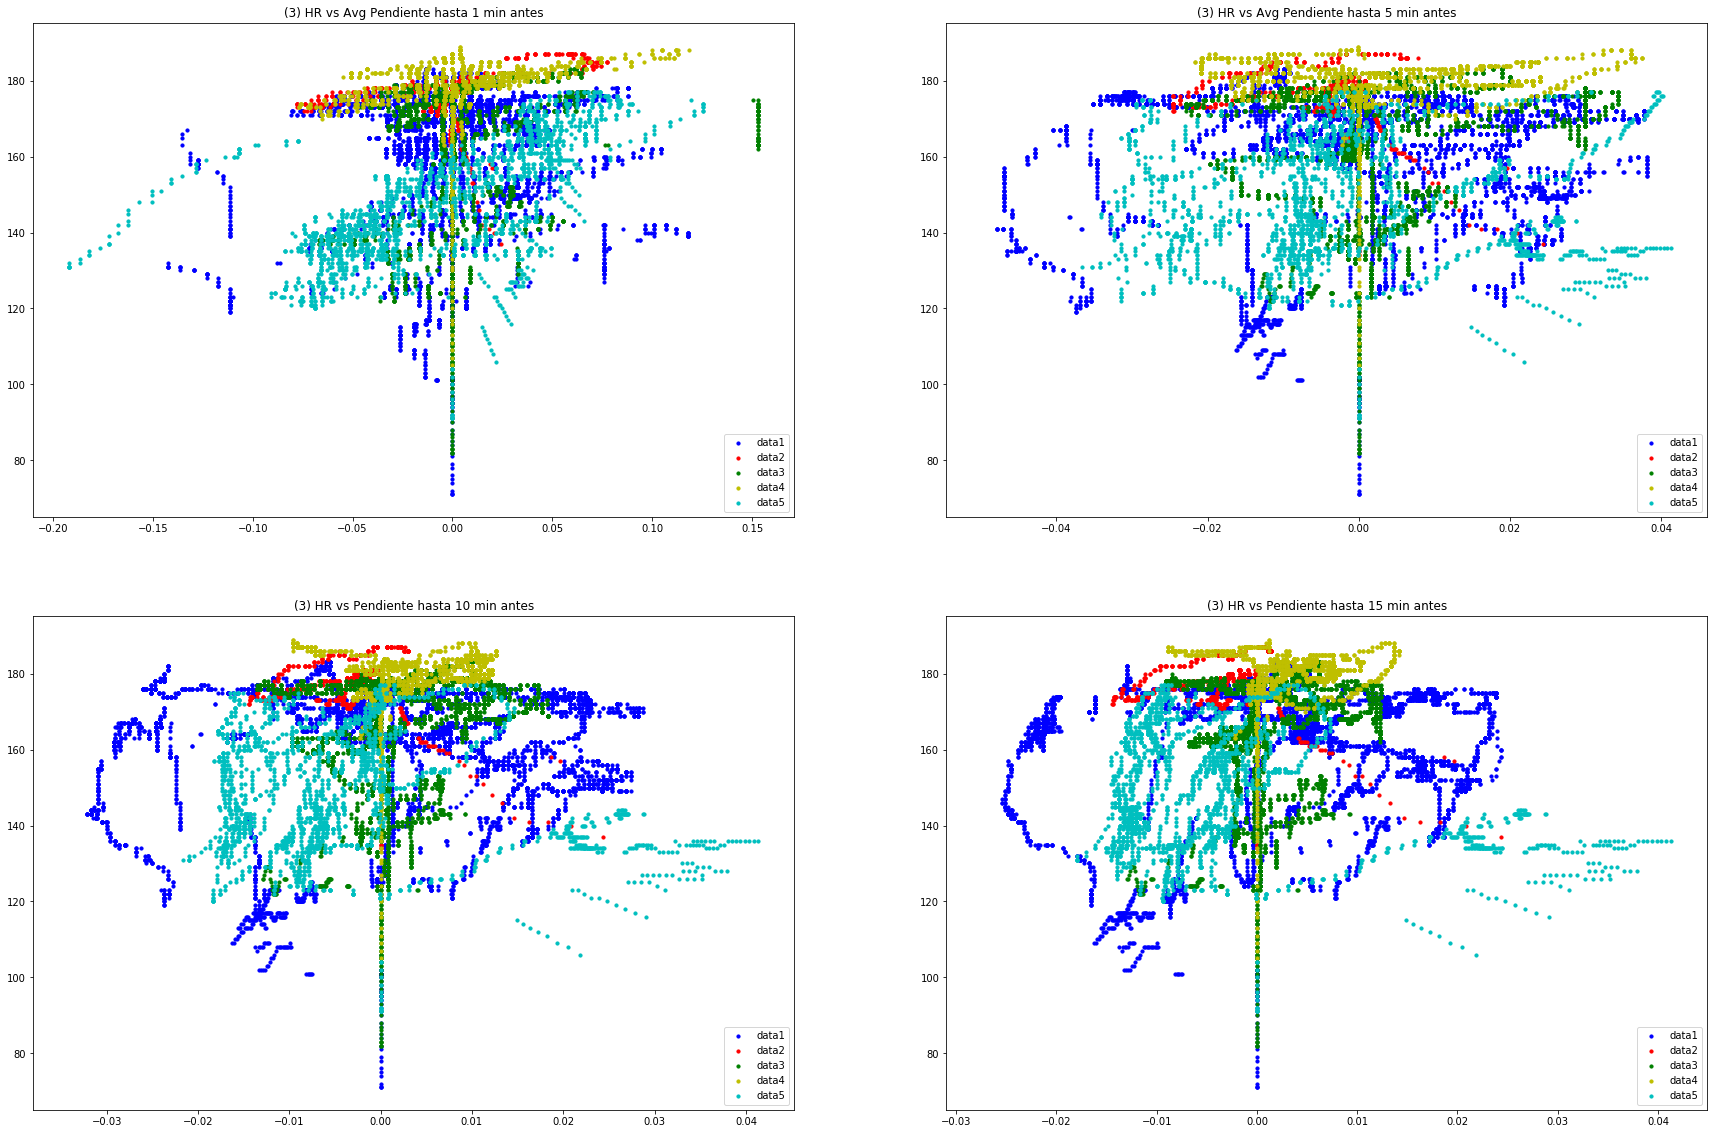

In [25]:
fig = plt.figure(figsize=(30,20))

andata1b = andata1[0:len(andata2)-1]
andata3b = andata3[0:len(andata2)-1]
andata4b = andata4[0:len(andata2)-1]
andata5b = andata5[0:len(andata2)-1]


ax1 = fig.add_subplot(221)
aux=ax1.scatter(andata1.ventAvgP_1_min, andata1.hr, s=10, c='b',marker="o", label='data1')
aux=ax1.scatter(andata2.ventAvgP_1_min, andata2.hr, s=10, c='r', marker="o", label='data2')
aux=ax1.scatter(andata3.ventAvgP_1_min, andata3.hr, s=10, c='g', marker="o", label='data3')
aux=ax1.scatter(andata4.ventAvgP_1_min, andata4.hr, s=10, c='y', marker="o", label='data4')
aux=ax1.scatter(andata5.ventAvgP_1_min, andata5.hr, s=10, c='c', marker="o", label='data5')
aux=plt.legend(loc='lower right');
aux=plt.title("(3) HR vs Avg Pendiente hasta 1 min antes")

ax1 = fig.add_subplot(222)
aux=ax1.scatter(andata1.ventAvgP_5_min, andata1.hr, s=10, c='b',marker="o", label='data1')
aux=ax1.scatter(andata2.ventAvgP_5_min, andata2.hr, s=10, c='r', marker="o", label='data2')
aux=ax1.scatter(andata3.ventAvgP_5_min, andata3.hr, s=10, c='g', marker="o", label='data3')
aux=ax1.scatter(andata4.ventAvgP_5_min, andata4.hr, s=10, c='y', marker="o", label='data4')
aux=ax1.scatter(andata5.ventAvgP_5_min, andata5.hr, s=10, c='c', marker="o", label='data5')
aux=plt.legend(loc='lower right');
aux=plt.title("(3) HR vs Avg Pendiente hasta 5 min antes")

ax1 = fig.add_subplot(223)
aux=ax1.scatter(andata1.ventAvgP_10_min, andata1.hr, s=10, c='b',marker="o", label='data1')
aux=ax1.scatter(andata2.ventAvgP_10_min, andata2.hr, s=10, c='r', marker="o", label='data2')
aux=ax1.scatter(andata3.ventAvgP_10_min, andata3.hr, s=10, c='g', marker="o", label='data3')
aux=ax1.scatter(andata4.ventAvgP_10_min, andata4.hr, s=10, c='y', marker="o", label='data4')
aux=ax1.scatter(andata5.ventAvgP_10_min, andata5.hr, s=10, c='c', marker="o", label='data5')
aux=plt.legend(loc='lower right');
aux=plt.title("(3) HR vs Pendiente hasta 10 min antes")

ax1 = fig.add_subplot(224)
aux=ax1.scatter(andata1.ventAvgP_15_min, andata1.hr, s=10, c='b',marker="o", label='data1')
aux=ax1.scatter(andata2.ventAvgP_15_min, andata2.hr, s=10, c='r', marker="o", label='data2')
aux=ax1.scatter(andata3.ventAvgP_15_min, andata3.hr, s=10, c='g', marker="o", label='data3')
aux=ax1.scatter(andata4.ventAvgP_15_min, andata4.hr, s=10, c='y', marker="o", label='data4')
aux=ax1.scatter(andata5.ventAvgP_15_min, andata5.hr, s=10, c='c', marker="o", label='data5')
aux=plt.legend(loc='lower right');
aux=plt.title("(3) HR vs Pendiente hasta 15 min antes")


aux=plt.show()

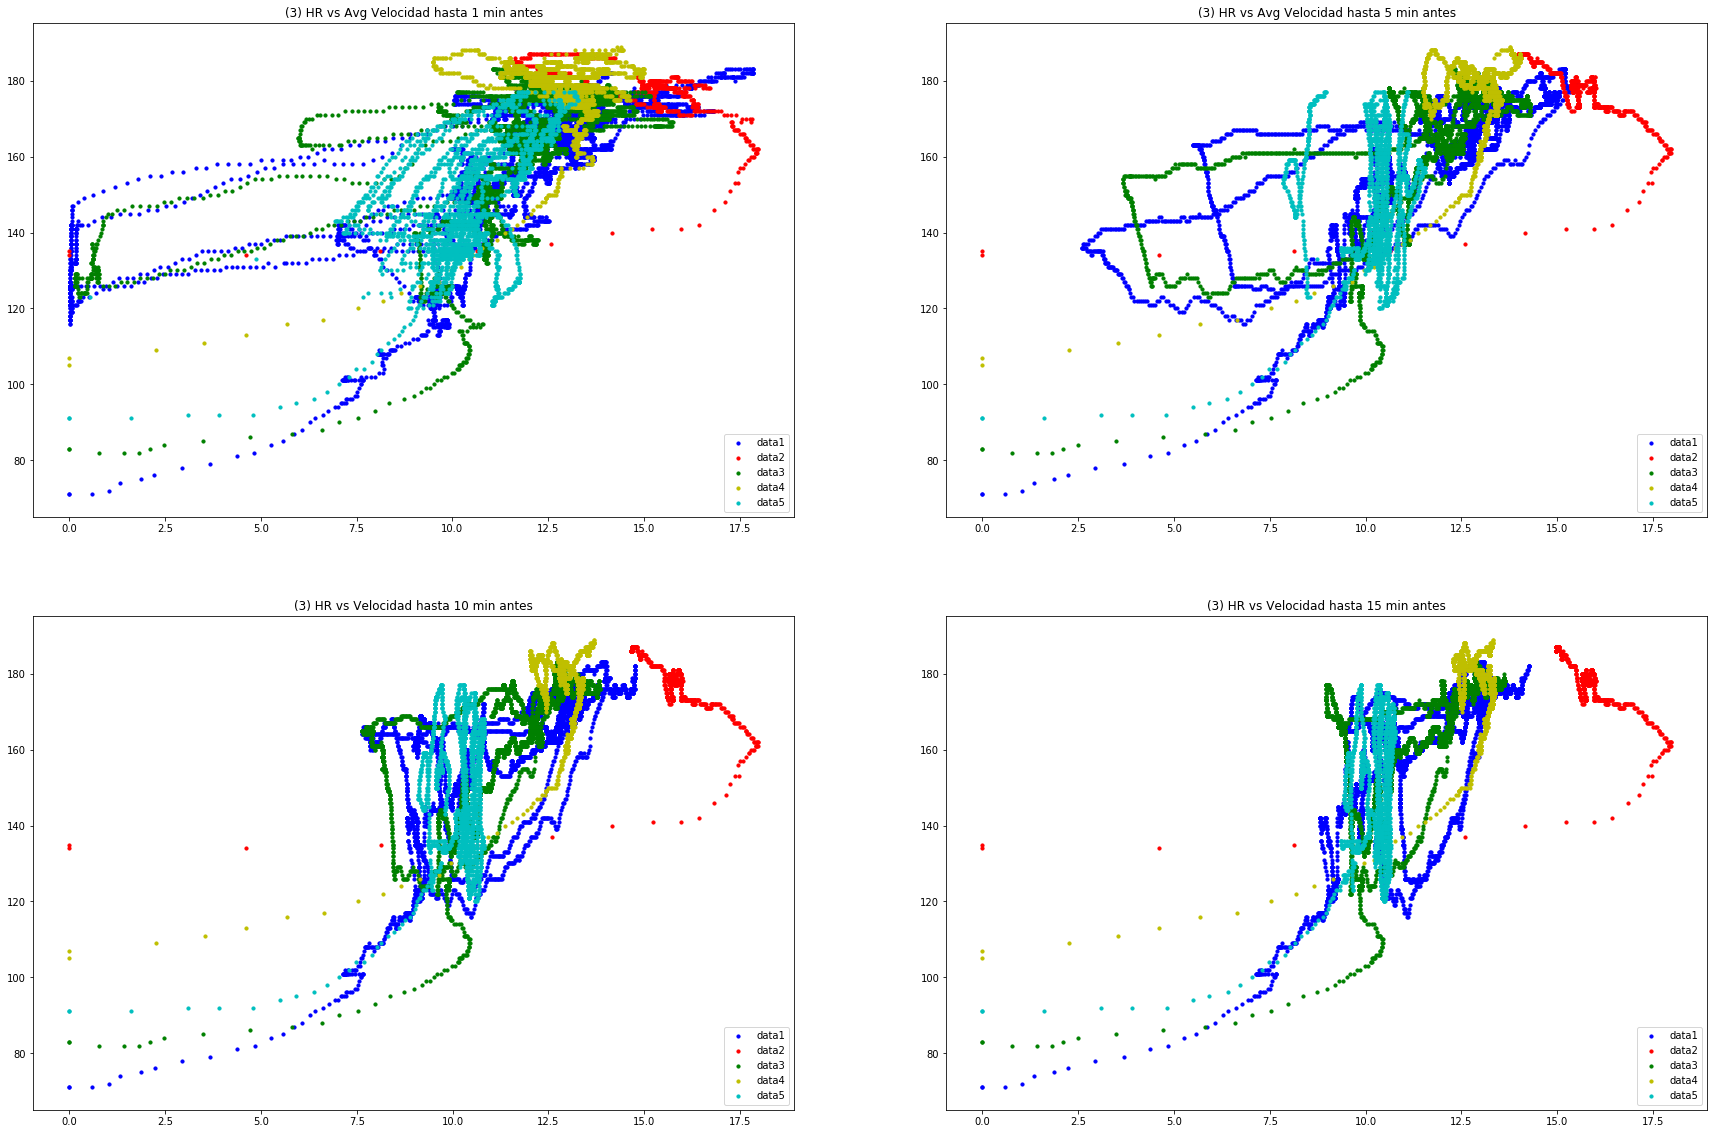

In [26]:
fig = plt.figure(figsize=(30,20))

andata1b = andata1[0:len(andata2)-1]
andata3b = andata3[0:len(andata2)-1]
andata4b = andata4[0:len(andata2)-1]
andata5b = andata5[0:len(andata2)-1]


ax1 = fig.add_subplot(221)
aux=ax1.scatter(andata1.ventAvgV_1_min, andata1.hr, s=10, c='b',marker="o", label='data1')
aux=ax1.scatter(andata2.ventAvgV_1_min, andata2.hr, s=10, c='r', marker="o", label='data2')
aux=ax1.scatter(andata3.ventAvgV_1_min, andata3.hr, s=10, c='g', marker="o", label='data3')
aux=ax1.scatter(andata4.ventAvgV_1_min, andata4.hr, s=10, c='y', marker="o", label='data4')
aux=ax1.scatter(andata5.ventAvgV_1_min, andata5.hr, s=10, c='c', marker="o", label='data5')
aux=plt.legend(loc='lower right');
aux=plt.title("(3) HR vs Avg Velocidad hasta 1 min antes")

ax1 = fig.add_subplot(222)
aux=ax1.scatter(andata1.ventAvgV_5_min, andata1.hr, s=10, c='b',marker="o", label='data1')
aux=ax1.scatter(andata2.ventAvgV_5_min, andata2.hr, s=10, c='r', marker="o", label='data2')
aux=ax1.scatter(andata3.ventAvgV_5_min, andata3.hr, s=10, c='g', marker="o", label='data3')
aux=ax1.scatter(andata4.ventAvgV_5_min, andata4.hr, s=10, c='y', marker="o", label='data4')
aux=ax1.scatter(andata5.ventAvgV_5_min, andata5.hr, s=10, c='c', marker="o", label='data5')
aux=plt.legend(loc='lower right');
aux=plt.title("(3) HR vs Avg Velocidad hasta 5 min antes")

ax1 = fig.add_subplot(223)
aux=ax1.scatter(andata1.ventAvgV_10_min, andata1.hr, s=10, c='b',marker="o", label='data1')
aux=ax1.scatter(andata2.ventAvgV_10_min, andata2.hr, s=10, c='r', marker="o", label='data2')
aux=ax1.scatter(andata3.ventAvgV_10_min, andata3.hr, s=10, c='g', marker="o", label='data3')
aux=ax1.scatter(andata4.ventAvgV_10_min, andata4.hr, s=10, c='y', marker="o", label='data4')
aux=ax1.scatter(andata5.ventAvgV_10_min, andata5.hr, s=10, c='c', marker="o", label='data5')
aux=plt.legend(loc='lower right');
aux=plt.title("(3) HR vs Velocidad hasta 10 min antes")

ax1 = fig.add_subplot(224)
aux=ax1.scatter(andata1.ventAvgV_15_min, andata1.hr, s=10, c='b',marker="o", label='data1')
aux=ax1.scatter(andata2.ventAvgV_15_min, andata2.hr, s=10, c='r', marker="o", label='data2')
aux=ax1.scatter(andata3.ventAvgV_15_min, andata3.hr, s=10, c='g', marker="o", label='data3')
aux=ax1.scatter(andata4.ventAvgV_15_min, andata4.hr, s=10, c='y', marker="o", label='data4')
aux=ax1.scatter(andata5.ventAvgV_15_min, andata5.hr, s=10, c='c', marker="o", label='data5')
aux=plt.legend(loc='lower right');
aux=plt.title("(3) HR vs Velocidad hasta 15 min antes")


aux=plt.show()

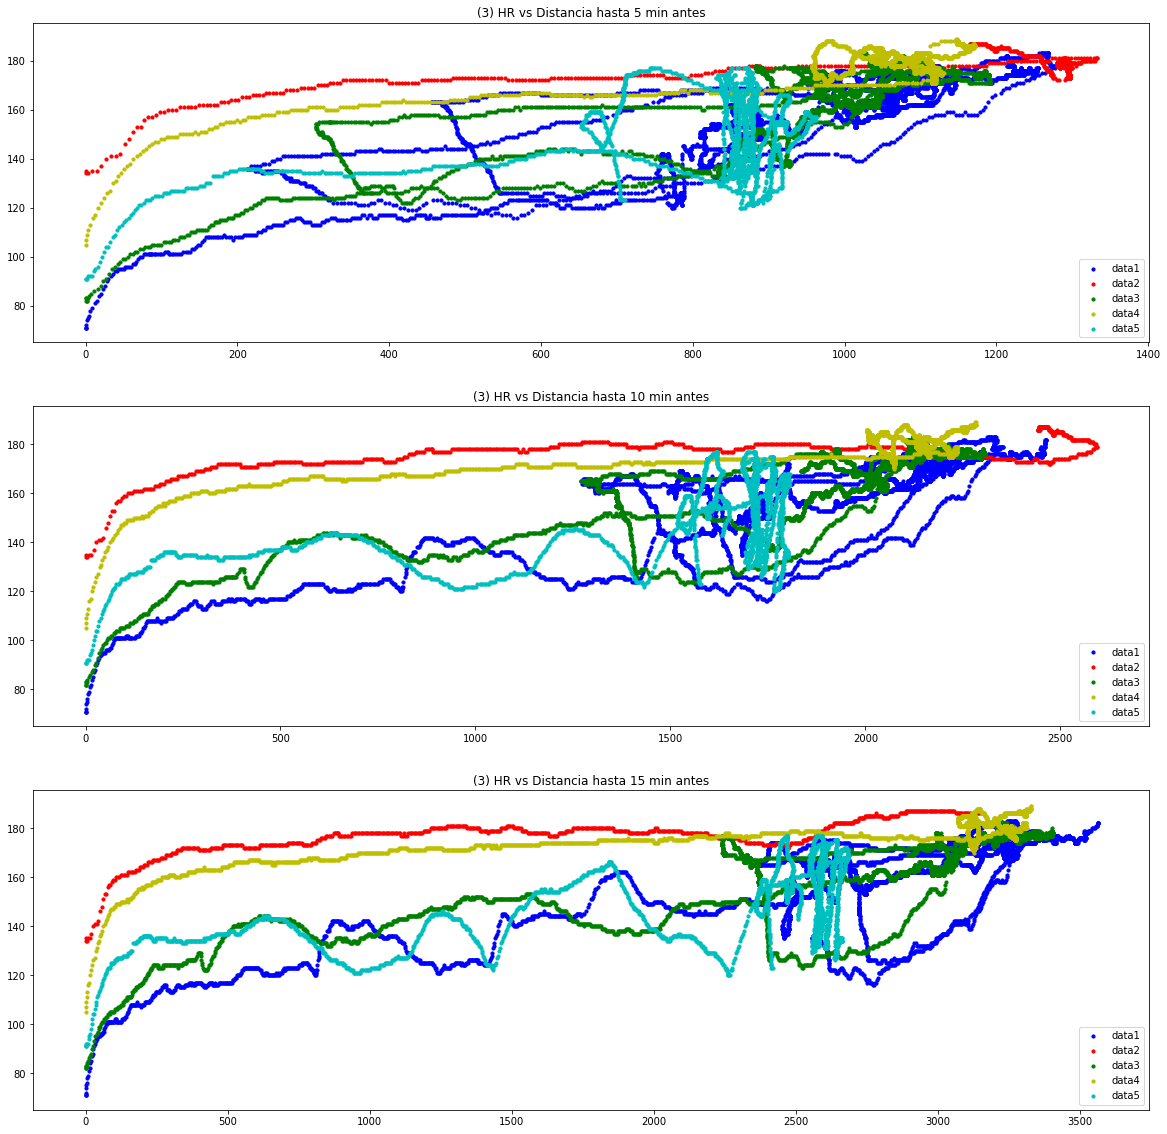

In [27]:
fig = plt.figure(figsize=(20,20))

andata1b = andata1[0:len(andata2)-1]
andata3b = andata3[0:len(andata2)-1]
andata4b = andata4[0:len(andata2)-1]
andata5b = andata5[0:len(andata2)-1]

ax1 = fig.add_subplot(311)
aux=ax1.scatter(andata1.ventDAcu_5_min, andata1.hr, s=10, c='b',marker="o", label='data1')
aux=ax1.scatter(andata2.ventDAcu_5_min, andata2.hr, s=10, c='r', marker="o", label='data2')
aux=ax1.scatter(andata3.ventDAcu_5_min, andata3.hr, s=10, c='g', marker="o", label='data3')
aux=ax1.scatter(andata4.ventDAcu_5_min, andata4.hr, s=10, c='y', marker="o", label='data4')
aux=ax1.scatter(andata5.ventDAcu_5_min, andata5.hr, s=10, c='c', marker="o", label='data5')
aux=plt.legend(loc='lower right');
aux=plt.title("(3) HR vs Distancia hasta 5 min antes")

ax1 = fig.add_subplot(312)
aux=ax1.scatter(andata1.ventDAcu_10_min, andata1.hr, s=10, c='b',marker="o", label='data1')
aux=ax1.scatter(andata2.ventDAcu_10_min, andata2.hr, s=10, c='r', marker="o", label='data2')
aux=ax1.scatter(andata3.ventDAcu_10_min, andata3.hr, s=10, c='g', marker="o", label='data3')
aux=ax1.scatter(andata4.ventDAcu_10_min, andata4.hr, s=10, c='y', marker="o", label='data4')
aux=ax1.scatter(andata5.ventDAcu_10_min, andata5.hr, s=10, c='c', marker="o", label='data5')
aux=plt.legend(loc='lower right');
aux=plt.title("(3) HR vs Distancia hasta 10 min antes")

ax1 = fig.add_subplot(313)
aux=ax1.scatter(andata1.ventDAcu_15_min, andata1.hr, s=10, c='b',marker="o", label='data1')
aux=ax1.scatter(andata2.ventDAcu_15_min, andata2.hr, s=10, c='r', marker="o", label='data2')
aux=ax1.scatter(andata3.ventDAcu_15_min, andata3.hr, s=10, c='g', marker="o", label='data3')
aux=ax1.scatter(andata4.ventDAcu_15_min, andata4.hr, s=10, c='y', marker="o", label='data4')
aux=ax1.scatter(andata5.ventDAcu_15_min, andata5.hr, s=10, c='c', marker="o", label='data5')
aux=plt.legend(loc='lower right');
aux=plt.title("(3) HR vs Distancia hasta 15 min antes")


aux=plt.show()

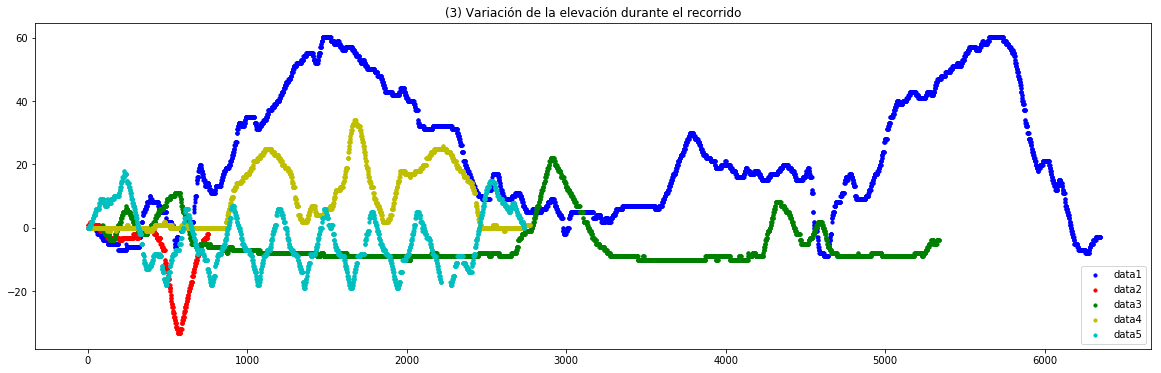

In [14]:
fig, ax1 = plt.subplots(figsize=(20,6))

aux=ax1.scatter(data1.seconds,data1.incEleAcu,  s=10, c='b',marker="o", label='data1')
aux=ax1.scatter(data2.seconds,data2.incEleAcu,  s=10, c='r', marker="o", label='data2')
aux=ax1.scatter(data3.seconds,data3.incEleAcu,  s=10, c='g', marker="o", label='data3')
aux=ax1.scatter( data4.seconds,data4.incEleAcu, s=10, c='y', marker="o", label='data4')
aux=ax1.scatter(data5.seconds,data5.incEleAcu,  s=10, c='c', marker="o", label='data5')
aux=plt.legend(loc='lower right');
aux=plt.title("(3) Variación de la elevación durante el recorrido")

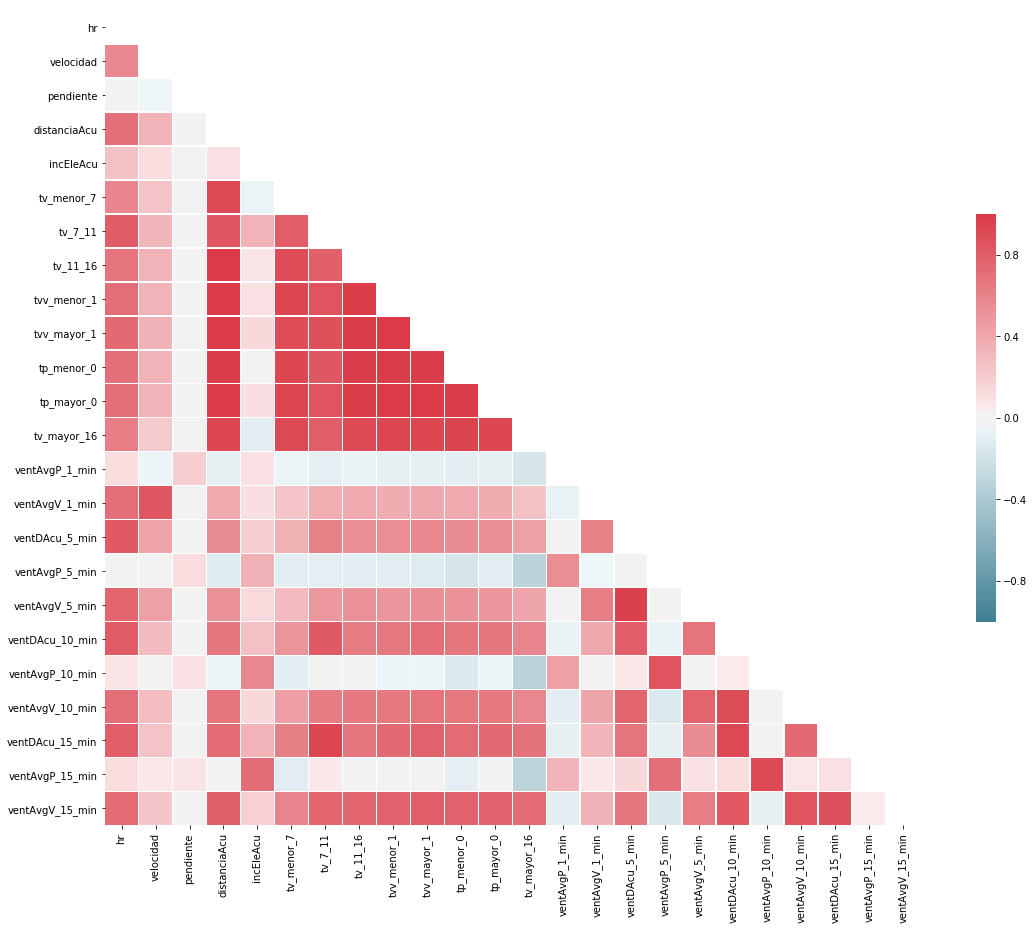

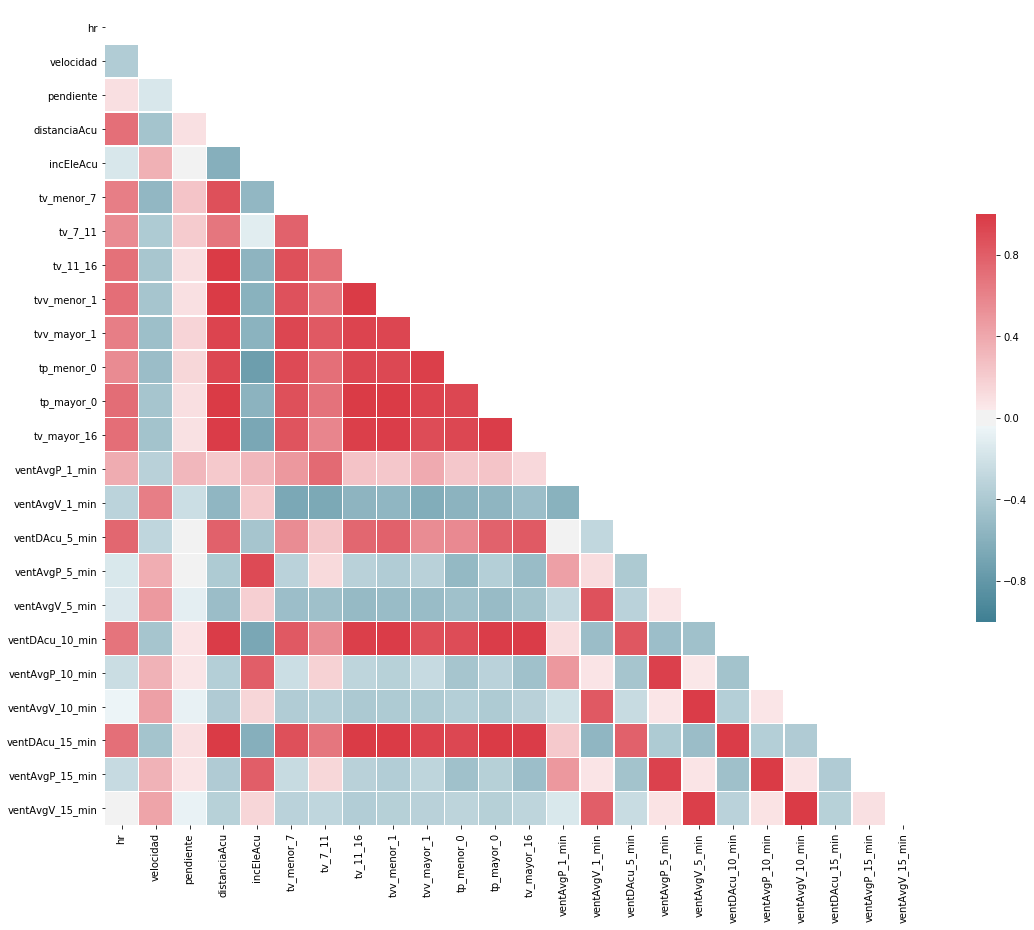

In [40]:
# sns.set(style="white")


f,ax = plt.subplots(figsize=(20,15))

#ax = f.add_subplot(121)
cor_mtx= andata1.corr()
mask= np.zeros_like(cor_mtx, dtype=np.bool)
mask[np.triu_indices_from(mask)]=True
cmap= sns.diverging_palette(220,10,as_cmap=True)
sns.heatmap(cor_mtx, mask=mask, cmap=cmap, vmax=1,vmin=-1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

f,ax = plt.subplots(figsize=(20,15))
# ax = f.add_subplot(122)
cor_mtx= andata2.corr()
mask= np.zeros_like(cor_mtx, dtype=np.bool)
mask[np.triu_indices_from(mask)]=True
cmap= sns.diverging_palette(220,10,as_cmap=True)
sns.heatmap(cor_mtx, mask=mask, cmap=cmap, vmax=1,vmin=-1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})


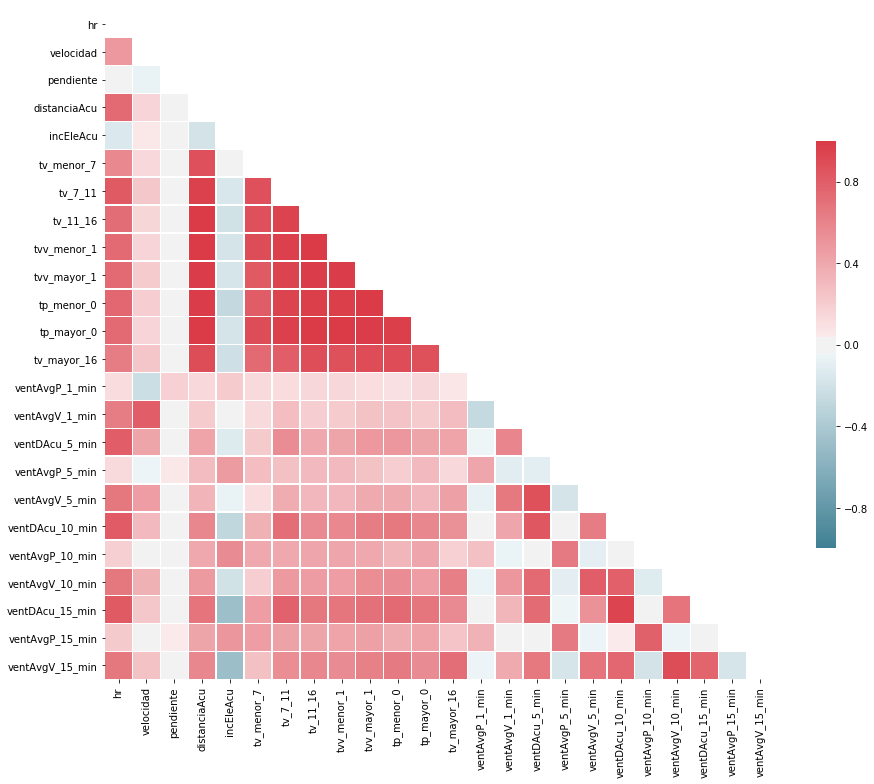

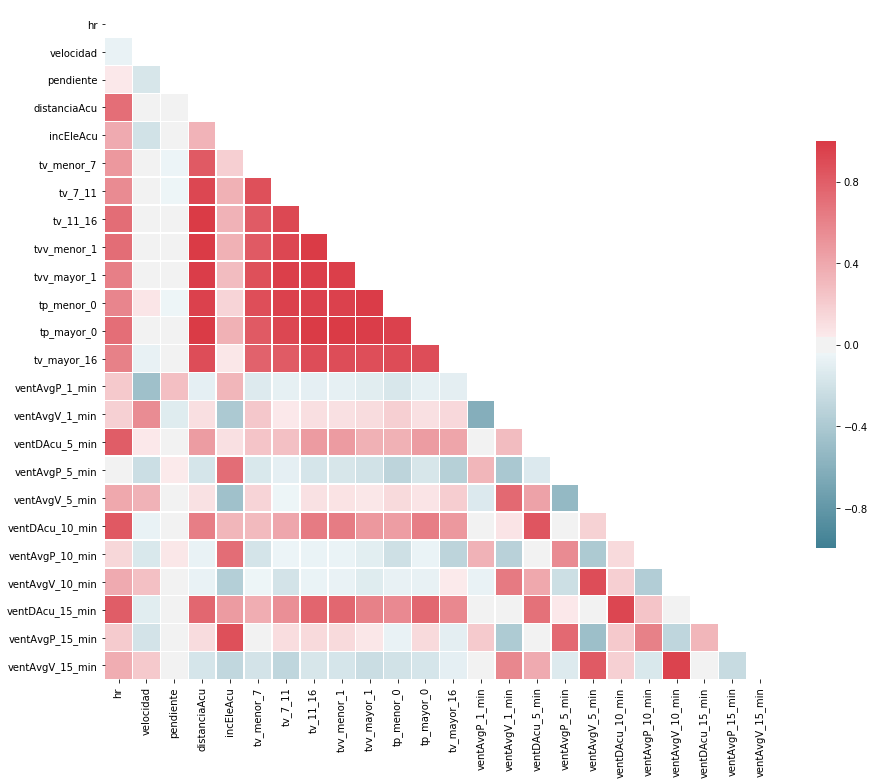

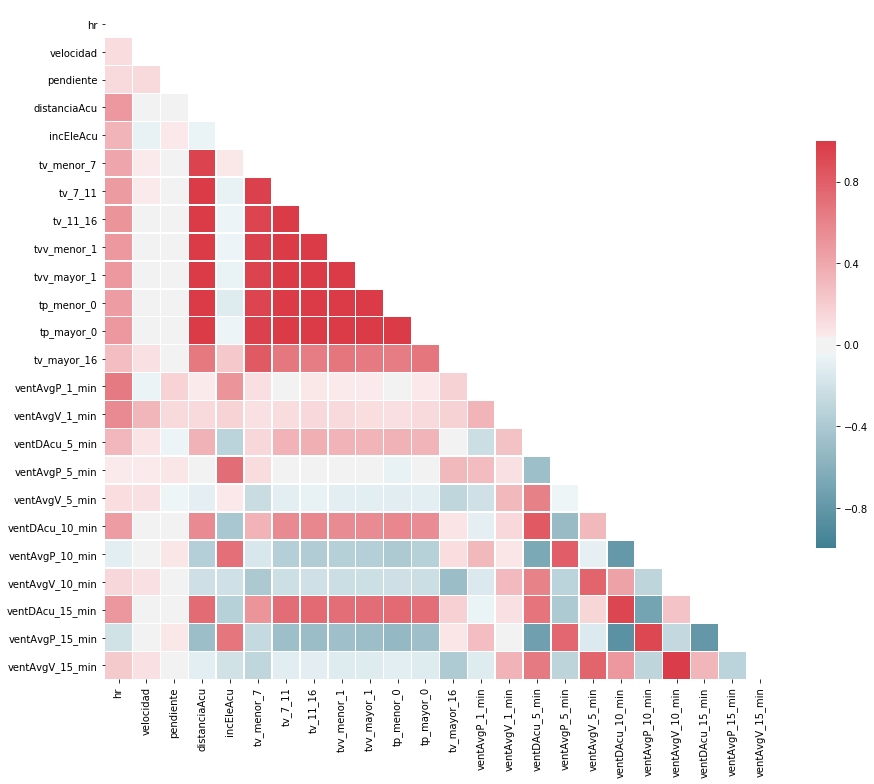

In [41]:
f,ax = plt.subplots(figsize=(15,15))
# ax = f.add_subplot(311)
cor_mtx= andata3.corr()
mask= np.zeros_like(cor_mtx, dtype=np.bool)
mask[np.triu_indices_from(mask)]=True
cmap= sns.diverging_palette(220,10,as_cmap=True)
sns.heatmap(cor_mtx, mask=mask, cmap=cmap, vmax=1,vmin=-1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

f,ax = plt.subplots(figsize=(15,15))

# ax = f.add_subplot(312)
cor_mtx= andata4.corr()
mask= np.zeros_like(cor_mtx, dtype=np.bool)
mask[np.triu_indices_from(mask)]=True
cmap= sns.diverging_palette(220,10,as_cmap=True)
sns.heatmap(cor_mtx, mask=mask, cmap=cmap, vmax=1,vmin=-1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

f,ax = plt.subplots(figsize=(15,15))

# ax = f.add_subplot(313)
cor_mtx= andata5.corr()
mask= np.zeros_like(cor_mtx, dtype=np.bool)
mask[np.triu_indices_from(mask)]=True
cmap= sns.diverging_palette(220,10,as_cmap=True)
sns.heatmap(cor_mtx, mask=mask, cmap=cmap, vmax=1,vmin=-1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})